## Generative Networks
### Conditional Generative Adversarial Networks (cGANs)

I originally wanted to create a CGAN based on the implementation during our class, but I just couldn't get it to work using BCE loss. Instead, I looked around the web and found out that MSE can be usued to achieve just as good results, and in this case, not only did the network work, but it is also 1/3rd of the size of original BCE network.

This network is based on pytorch's built-in labelled STL10 dataset. The labels are the following:
0. airplane  
1. bird  
2. car  
3. cat  
4. deer  
5. dog  
6. horse  
7. monkey  
8. ship  
9. truck

As usual, we start with the standard imports and package installations.

In [1]:
import os
import random
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

torch.cuda.is_available()

True

In [2]:
! pip install scikit-learn scikit-image matplotlib tqdm

# Define variables

In [3]:
workers = 2
batch_size = 50
nz = 100
nch_g = 64
nch_d = 64
n_epoch = 200
lr = 0.0002
beta1 = 0.5
outf = './result_cgan'
display_interval = 100

try:
    os.makedirs(outf)
except OSError:
    pass

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)



# Define functions

In [4]:
def weights_init(m):
    """
    These values are commonly used in GANs to stabilize training, make the learning process faster and more effective.
    Honestly I'm not sure if pytorch has already implemented these initializations by default, but I took inspiration from older code
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:  
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:  
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def onehot_encode(label:int, device:torch.device, n_classes:int=10):
    """
    Convert label to one-hot vector.

    Parameters:
        label: Label to be converted
        n_class: Number of classes

    Returns:
        Tensor of shape (B, c_class, 1, 1) to concatenate with an image later
    """
    eye = torch.eye(n_classes, device=device)
    return eye[label].view(-1, n_classes, 1, 1)  #  e.g. with 5 classes: label=2 -> [0,0,1,0,0]
                                                 # eye[label] is a 1D tensor of length n_classes, reshaped to a 4D Tensor for image compatability


def concat_image_label(image:torch.Tensor, label:int, device:torch.device, n_class:int=10):
    """
    Concatenate image and label one-hot vector.

    Parameters:
        image: Image Tensor of shape (Batch, Channel, Height, Width)
        label: Label Tensor of shape (Batch, n_classes)
        n_classes: Number of classes

    Returns:
        Concatenated Tensor of shape (B, C+n_classes, H, W)
    """
    B, C, H, W = image.shape    # Get the size of the image Tensor
    
    oh_label = onehot_encode(label, device)
    oh_label = oh_label.expand(B, n_class, H, W)  # Expand the label to fit the image size
    return torch.cat((image, oh_label), dim=1)  # Concatenate along tsshe channel dimension C




def concat_noise_label(noise, label, device):
    """
    Concatenate noise tensor and label one-hot vector for conditional GAN input.

    Parameters:
        noise (torch.Tensor): Noise tensor of shape (Batch, nz, 1, 1).
        label (int or torch.Tensor): Label(s) to be converted to one-hot encoding.
        device (torch.device): Device to place the tensors on.

    Returns:
        Tensor: Concatenated tensor of shape (Batch, nz + n_classes, 1, 1),
                      suitable for input to the generator in a conditional GAN.
    """
    oh_label = onehot_encode(label, device)
    return torch.cat((noise, oh_label), dim=1) # Concatenate along the channel dimension



# Define GAN

In [5]:
class Generator(nn.Module):
    def __init__(self, nz=100, nch_g=64, nch=3):
        """
        nz: The dimension of the input latent vector z
        nch_g: Number of channels in the final layer
        nch: Number of channels in the output image
        """
        super().__init__()
        
        # Define the structure of the NN
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.ConvTranspose2d(nz, nch_g * 8, 4, 1, 0),
                nn.BatchNorm2d(nch_g * 8),
                nn.LeakyReLU()
            ),  # (B, nz, 1, 1) -> (B, nch_g*8, 4, 4)
            'layer1': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 8, nch_g * 4, 4, 2, 1),
                nn.BatchNorm2d(nch_g * 4),
                nn.Dropout2d(p=0.3),
                nn.LeakyReLU()
            ),  # (B, nch_g*8, 4, 4) -> (B, nch_g*4, 8, 8)
            'layer2': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 4, nch_g * 2, 4, 2, 1),
                nn.BatchNorm2d(nch_g * 2),
                nn.LeakyReLU()
            ),  # (B, nch_g*4, 8, 8) -> (B, nch_g*2, 16, 16)

            'layer3': nn.Sequential(
                nn.ConvTranspose2d(nch_g * 2, nch_g, 4, 2, 1),
                nn.BatchNorm2d(nch_g),
                nn.Dropout2d(),
                nn.LeakyReLU()
            ),  # (B, nch_g*2, 16, 16) -> (B, nch_g, 32, 32)
            'layer4': nn.Sequential(
                nn.ConvTranspose2d(nch_g, nch, 4, 2, 1),
                nn.Tanh()
            )   # (B, nch_g, 32, 32) -> (B, nch, 64, 64)
        })

    def forward(self, z):
        """
        param z: Input vector
        return: Generated image
        """
        for layer in self.layers.values():  # Perform each operation of self.layers
            z = layer(z)
        return z
    
    
class Discriminator(nn.Module):
    def __init__(self, nch=3, nch_d=64):
        '''
        nch: Number of channels in the output image
        nch_d: Number of channels in the final layer
        '''
        super().__init__()

        # Define the structure of the NN
        self.layers = nn.ModuleDict({
            'layer0': nn.Sequential(
                nn.Conv2d(nch, nch_d, 4, 2, 1),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch, 64, 64) -> (B, nch_d, 32, 32)
            'layer1': nn.Sequential(
                nn.Conv2d(nch_d, nch_d * 2, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 2),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d, 32, 32) -> (B, nch_d*2, 16, 16)
            'layer2': nn.Sequential(
                nn.Conv2d(nch_d * 2, nch_d * 4, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 4),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d*2, 16, 16) -> (B, nch_d*4, 8, 8)
            'layer3': nn.Sequential(
                nn.Conv2d(nch_d * 4, nch_d * 8, 4, 2, 1),
                nn.BatchNorm2d(nch_d * 8),
                nn.LeakyReLU(negative_slope=0.2)
            ),  # (B, nch_d*4, 8, 8) -> (B, nch_g*8, 4, 4)
            'layer4': nn.Conv2d(nch_d * 8, 1, 4, 1, 0)
            # (B, nch_d*8, 4, 4) -> (B, 1, 1, 1)
        })

    def forward(self, x):
        '''
        x: Original or generated image
        return: Discrimination signal
        '''
        for layer in self.layers.values():  # Perform each operation of self.layers
            x = layer(x)
        return x.squeeze()  # Tensor with shape (B)

# Import Dataset

In [6]:
trainset = dset.STL10(root='./data', download=True, split='train',
                      transform=transforms.Compose([
                          transforms.RandomResizedCrop(64, scale=(88/96, 1.0), ratio=(1., 1.)),
                          transforms.RandomHorizontalFlip(),
                          transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                      ])) # Do not inculude the unlabeled data
testset = dset.STL10(root='./data', download=True, split='test',
                     transform=transforms.Compose([
                         transforms.RandomResizedCrop(64, scale=(88/96, 1.0), ratio=(1., 1.)),
                         transforms.RandomHorizontalFlip(),
                         transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                     ]))
dataset = trainset + testset

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=int(workers))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


# Apply Nets

In [7]:
# G generates fake images from random noise and labels
netG = Generator(nz=nz+10, nch_g=nch_g).to(device)  # The input vector dimension is the sum of the random vector dimension nz and the number of classes 10
netG.apply(weights_init)
print(netG)

# D determines whether the input image is real or fake, conditioned on labels
netD = Discriminator(nch=3+10, nch_d=nch_d).to(device)  # The number of channels in the input Tensor is the sum of the image channels (3, since we use RGB) and the number of classes 10
netD.apply(weights_init)
print(netD)

Generator(
  (layers): ModuleDict(
    (layer0): Sequential(
      (0): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (layer1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout2d(p=0.3, inplace=False)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (layer2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (layer3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [8]:
criterion = nn.MSELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

fixed_label = [i for i in range(10)] * (batch_size // 10)  # Labels from 0-9 repeated to match batch size
fixed_label = torch.tensor(fixed_label, dtype=torch.long, device=device)

fixed_noise_label = concat_noise_label(fixed_noise, fixed_label, device)  # 確認用のノイズとラベルを連結

# Train Model

In [9]:
G_losses = []
D_losses = []

for epoch in range(n_epoch):
    for itr, data in enumerate(dataloader):
        real_image = data[0].to(device)  
        real_label = data[1].to(device)  
        real_image_label = concat_image_label(real_image, real_label, device)

        sample_size = real_image.size(0)
        noise = torch.randn(sample_size, nz, 1, 1, device=device)
        fake_label = torch.randint(10, (sample_size,), dtype=torch.long, device=device)  # 贋作画像生成用のラベル
        fake_noise_label = concat_noise_label(noise, fake_label, device)  # ノイズとラベルを連結
        
        real_target = torch.full((sample_size,), 1., device=device)
        fake_target = torch.full((sample_size,), 0., device=device)

        ############################
        # Update Discriminator D
        ###########################
        netD.zero_grad()

        output = netD(real_image_label)  # Get an identification signal for the combination of real images and labels
        errD_real = criterion(output, real_target)        
        D_x = output.mean().item()

        fake_image = netG(fake_noise_label)  # Generate fake images from noise and labels
        fake_image_label = concat_image_label(fake_image, fake_label, device)  # Concat the newly generated fake images with their labels

        output = netD(fake_image_label.detach())  # THe Discriminator evaluates the fake images and labels combination
        errD_fake = criterion(output, fake_target)
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        ############################
        # Update Generator G
        ###########################
        netG.zero_grad()
        
        output = netD(fake_image_label)  # The updated Discriminator evaluates the fake images and labels combination
        errG = criterion(output, real_target)
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()

        if itr % display_interval == 0:
            print('[{}/{}][{}/{}]\n\tLoss_D: {:.3f} Loss_G: {:.3f} D(x): {:.3f} D(G(z)): {:.3f}/{:.3f}'
                  .format(epoch + 1, n_epoch,
                          itr + 1, len(dataloader),
                          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())  
        D_losses.append(errD.item())

        if epoch == 0 and itr == 0:
            vutils.save_image(real_image, '{}/real_samples.png'.format(outf),
                              normalize=True, nrow=10)

    ############################
    # Generate and save fake images for fixed noise and labels
    ############################
    fake_image = netG(fixed_noise_label)  # At the end of each epoch, generate fake images corresponding to the specified labels
    vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch + 1),
                      normalize=True, nrow=10)

[1/200][1/260]
	Loss_D: 3.633 Loss_G: 15.611 D(x): -0.180 D(G(z)): -0.178/2.842
[1/200][101/260]
	Loss_D: 0.328 Loss_G: 1.389 D(x): 0.825 D(G(z)): 0.152/-0.148
[1/200][201/260]
	Loss_D: 0.319 Loss_G: 0.338 D(x): 0.585 D(G(z)): -0.058/0.444
[2/200][1/260]
	Loss_D: 0.946 Loss_G: 1.589 D(x): 0.789 D(G(z)): 0.780/-0.223
[2/200][101/260]
	Loss_D: 0.334 Loss_G: 0.620 D(x): 0.823 D(G(z)): 0.302/0.240
[2/200][201/260]
	Loss_D: 0.403 Loss_G: 0.695 D(x): 0.700 D(G(z)): 0.354/0.200
[3/200][1/260]
	Loss_D: 0.304 Loss_G: 0.885 D(x): 0.861 D(G(z)): 0.180/0.114
[3/200][101/260]
	Loss_D: 0.652 Loss_G: 0.697 D(x): 0.566 D(G(z)): 0.567/0.204
[3/200][201/260]
	Loss_D: 0.479 Loss_G: 0.687 D(x): 0.634 D(G(z)): 0.415/0.241
[4/200][1/260]
	Loss_D: 0.557 Loss_G: 1.003 D(x): 0.525 D(G(z)): 0.401/0.056
[4/200][101/260]
	Loss_D: 0.620 Loss_G: 0.526 D(x): 0.429 D(G(z)): 0.363/0.330
[4/200][201/260]
	Loss_D: 0.592 Loss_G: 0.566 D(x): 0.891 D(G(z)): 0.652/0.287
[5/200][1/260]
	Loss_D: 1.037 Loss_G: 1.973 D(x): 1.24

# Visualize Losses

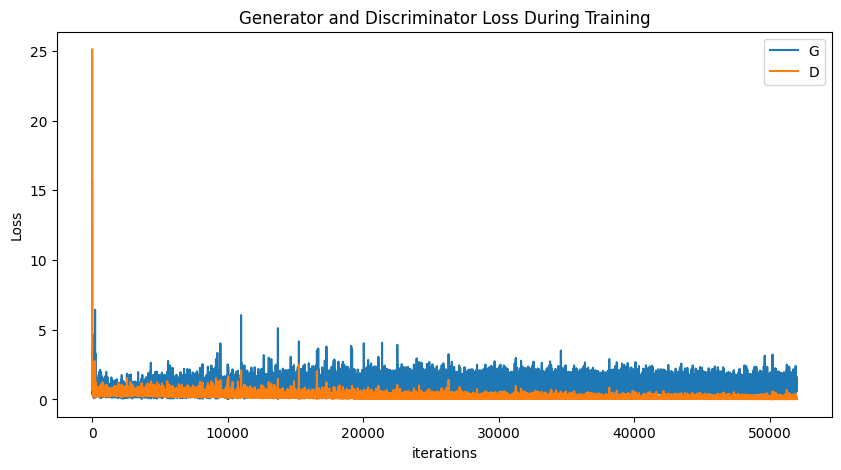

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title('Generator and Discriminator Loss During Training')
plt.plot(G_losses,label='G')
plt.plot(D_losses,label='D')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Create GIF

In [ ]:
import matplotlib
import matplotlib.animation as animation
from IPython.display import HTML

# Allocate memory for gif
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Store images
img_list = []
for epoch in range(n_epoch):
    img = plt.imread('{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch + 1))
    img_list.append(img)

# Display gif
fig = plt.figure(figsize=(10,10))
plt.axis('off')
ims = [[plt.imshow(i, animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# Save gif
ani.save('{}/fake_imgs.gif'.format(outf), writer="pillow", fps=5)

plt.close()

HTML(ani.to_jshtml())

# Show results

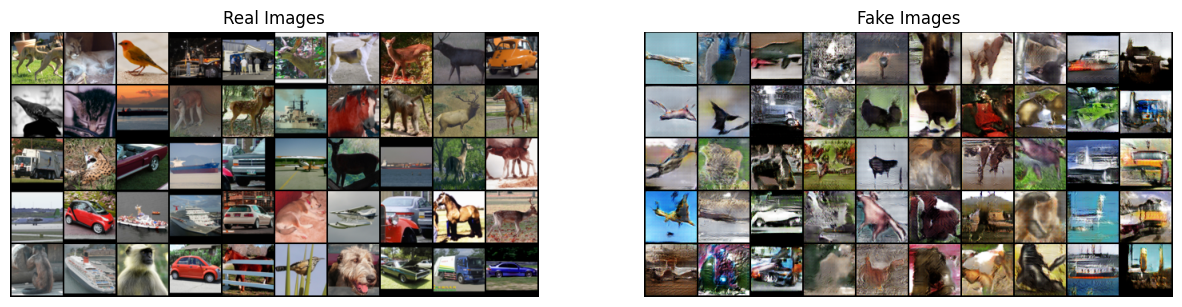

In [12]:
from PIL import Image
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.axis('off')
plt.title('Real Images')
img = Image.open('{}/real_samples.png'.format(outf))
plt.imshow(img)

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Fake Images')
plt.imshow(img_list[-1])
plt.show()